# Non Temporal CNN approach

In [1]:
# Import required libraries
import pandas as pd
import src.dataPreparation as prep
import numpy as np
import tensorflow as tf
import tests.timeseriestesting as tst

In [2]:
# Import data
ibm = pd.read_csv('../data/ibm_historical.csv')
msft = pd.read_csv('../data/msft_historical.csv')
nvda = pd.read_csv('../data/nvda_historical.csv')

# Drop Date column
ibm.drop(columns=['Date'], inplace=True)
msft.drop(columns=['Date'], inplace=True)
nvda.drop(columns=['Date'], inplace=True)

# Create target variables
ibm = prep.calculateTarget(ibm)
msft = prep.calculateTarget(msft)
nvda = prep.calculateTarget(nvda)

# Create train and test sets
ibm_train, ibm_test = ibm[:-858], ibm[-858:]
msft_train, msft_test = msft[:-858], msft[-858:]
nvda_train, nvda_test = nvda[:-858], nvda[-858:]


Metal device set to: Apple M1 Pro


2022-10-11 10:42:17.043273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-11 10:42:17.043401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Transform for modelling
window = 5

ibm_train_X, ibm_train_y = prep.nonTemporalTransform(
    ibm_train.drop(columns=['target']),
    ibm_train['target'],
    window_size=window
)

msft_train_X, msft_train_y = prep.nonTemporalTransform(
    msft_train.drop(columns=['target']),
    msft_train['target'],
    window_size=window
)

nvda_train_X, nvda_train_y = prep.nonTemporalTransform(
    nvda_train.drop(columns=['target']),
    nvda_train['target'],
    window_size=window
)

# Shuffle training tensors
ibm_train_X, ibm_train_y = prep.shuffle_tensors(ibm_train_X, ibm_train_y)
msft_train_X, msft_train_y = prep.shuffle_tensors(msft_train_X, msft_train_y)
nvda_train_X, nvda_train_y = prep.shuffle_tensors(nvda_train_X, nvda_train_y)


In [ ]:
# Create validation tests
ibm_train_X, ibm_val_X, ibm_train_y, ibm_val_y = ibm_train_X[:-858], ibm_train_X[-858:], ibm_train_y[:-858], ibm_train_y[-858:]
msft_train_X, msft_val_X, msft_train_y, msft_val_y = msft_train_X[:-858], msft_train_X[-858:], msft_train_y[:-858], msft_train_y[-858:]
nvda_train_X, nvda_val_X, nvda_train_y, nvda_val_y = nvda_train_X[:-858], nvda_train_X[-858:], nvda_train_y[:-858], nvda_train_y[-858:]

In [3]:
# 1. Create the model
model_1 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv1D(8, kernel_size=(1), activation='relu'),
        tf.keras.layers.Conv1D(8, kernel_size=(1), activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=(1)),
        tf.keras.layers.Conv1D(8, kernel_size=(1), activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=(1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

# 2. Compile the model
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 3. Fit the model
history = model_1.fit(
    ibm_train_X, tf.cast(ibm_train_y, dtype=tf.int32),
    epochs=100
)

# 4. Evaluate the model with the validation set
model_1.evaluate(ibm_val_X, ibm_val_y)

Epoch 1/100


2022-10-11 10:42:21.429358: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/126 [..............................] - ETA: 55s - loss: 213803.2656 - accuracy: 0.5625

2022-10-11 10:42:21.689080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 8ms/step - loss: 101247.1641 - accuracy: 0.4919
Epoch 2/100
126/126 [==============================] - 1s 8ms/step - loss: 41891.9961 - accuracy: 0.4946
Epoch 3/100
126/126 [==============================] - 1s 8ms/step - loss: 11572.9541 - accuracy: 0.5024
Epoch 4/100
126/126 [==============================] - 1s 8ms/step - loss: 18.4251 - accuracy: 0.5216
Epoch 5/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6924 - accuracy: 0.5246
Epoch 6/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6922 - accuracy: 0.5246
Epoch 7/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6921 - accuracy: 0.5246
Epoch 8/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6920 - accuracy: 0.5246
Epoch 9/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6920 - accuracy: 0.5246
Epoch 10/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6920 - accu

2022-10-11 10:44:00.502008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.4907


[0.6954105496406555, 0.49067601561546326]

0it [00:00, ?it/s]2022-10-11 10:44:00.898633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
4005it [01:45, 37.97it/s]


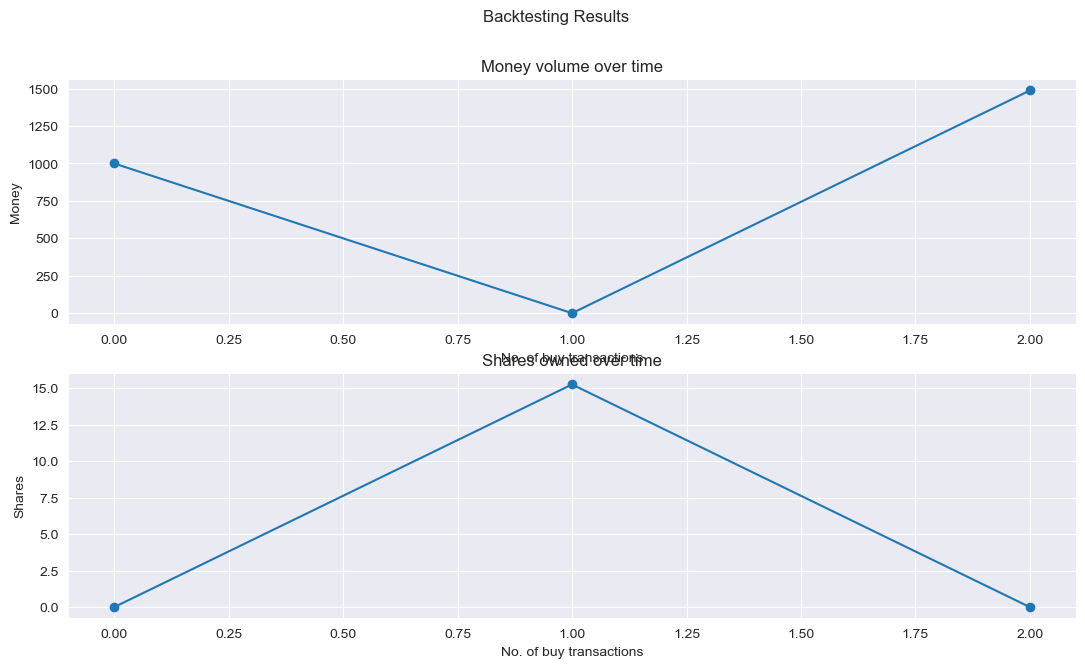

In [4]:
# Define assets
assets = tst.Assets(money=1000)

# Run testing run
predictions = tst.testing_run(assets=assets, model=model_1, test_data=ibm_train_X) # TODO Use correct test data

# Plot testing results
tst.plot_testing_run(assets)

In [5]:
assets.get_history()

([1000, 0, 1487.36446212425], [0, 15.262687584028129, 0])

In [6]:
predictions[:10], predictions[-10:]

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [7]:
sum(ibm_train_y)/ibm_train_y.shape[0], sum(ibm_val_y)/ibm_val_y.shape[0]

(<tf.Tensor: shape=(), dtype=float64, numpy=0.5245942571785268>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.49067599067599066>)

### Notes
`Model_1` is not great. It has poor accuracy results over both the train and validation sets. Looking at this further the models predictions are only the positive class.

There are two directions this could now take. Change of neural architecture and change of data treatment.

`Model_2` will transform the data inside along the first axis. The plan is to normalize the following columns so that they are between 0 and 1.
* Open
* High
* Low
* Close
* Volume

The first four will be normalized together and Volume will be normalized by itself to prevent the distribution of values being bimodal.